In [34]:
import matplotlib.pyplot as plt
import numpy as np

import cmbo
from IPython.display import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
center = np.full((3,), 681 / 2)

x_halo, masses, opt = cmbo.io.load_halo_positions_masses(
    "/Users/rstiskalek/Projects/CMBOlympics/data/manticore_fof.hdf5",
    "Coordinates", "Group_M_Crit200", nsim=0, r_max=1000, mass_min=1e10,
    optional_keys=['Group_R_Crit200']
    )

masses /= 0.681

r = np.linalg.norm(x_halo - center, axis=1)
ra, dec = cmbo.utils.cartesian_to_radec(x_halo, center)
z = cmbo.utils.comoving_distance_to_cz(r) / cmbo.constants.SPEED_OF_LIGHT_KMS


theta = np.arctan(opt['Group_R_Crit200'] / r)


m = masses > 5e13

ra, dec, masses, theta, z = ra[m], dec[m], masses[m], theta[m], z[m]

data = np.column_stack((ra, dec, z, masses))
np.savetxt("halos_ra_dec_z_mass.txt", data,
           fmt="%.8e %.8e %.8e %.8e",
           header="ra dec z mass", comments="# ")


In [4]:
pars = cmbo.mapgen.GNFWParameters()
profile = cmbo.mapgen.GNFWProfile(pars)

mapgen = cmbo.mapgen.TSZMap(nside=256, profile=profile)

m = mapgen.paint(ra, dec, masses, theta, z)

Painting 1539 halos onto Healpix nside=256 (npix=786432), batch_size=256
  processed halos 0:256 (256 in batch)
  processed halos 256:512 (256 in batch)
  processed halos 512:768 (256 in batch)
  processed halos 768:1024 (256 in batch)
  processed halos 1024:1280 (256 in batch)
  processed halos 1280:1536 (256 in batch)
  processed halos 1536:1539 (3 in batch)


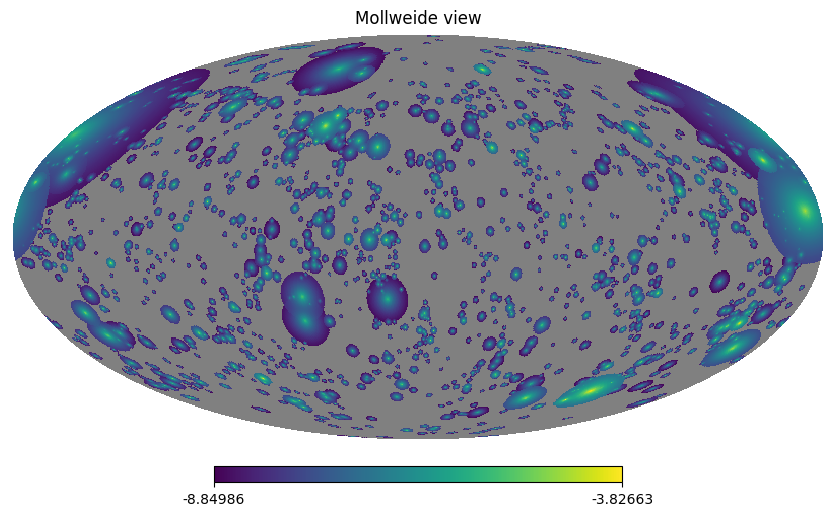

In [5]:
import healpy as hp

m = np.array(m)

m[m == 0] = np.nan

hp.mollview(np.log10(m))

In [8]:
mnew = np.loadtxt("/Users/rstiskalek/Projects/XGPaint/sz_map_pixels.txt")
mnew[mnew == 0] = np.nan

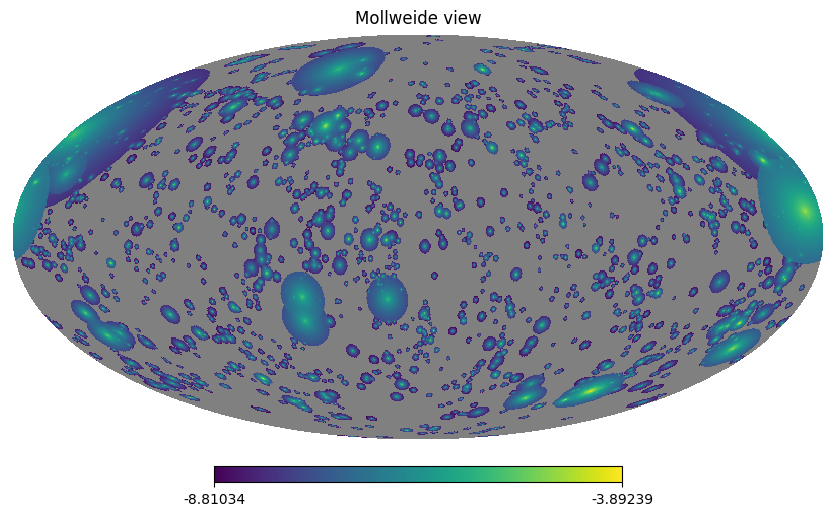

In [9]:
import healpy as hp



hp.mollview(np.log10(mnew))

In [19]:
from astropy.cosmology import FlatLambdaCDM


cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)

In [36]:
cosmo.age(-0.99)

<Quantity 92.0406649 Gyr>

In [46]:
zf = -0.9

1 / (1 + zf)

10.000000000000002

In [ ]:
dm = m - mnew

dm = dm[np.isfinite(dm)]

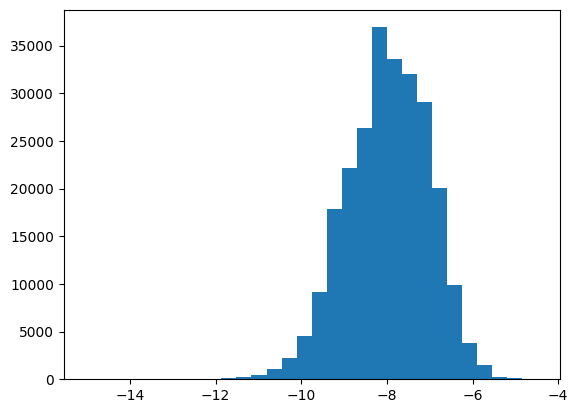

In [18]:
plt.figure()
plt.hist(np.log10(np.abs(dm)), bins=30)
plt.show()

In [24]:
groups = cmbo.match.fof_tessellation(x_obs, x_halo, linking_length=3)
groups_prob = cmbo.match.compute_group_probabilities(x_obs, x_halo, 1, groups)

In [25]:
# model = cmbo.match.AssociationModel(groups, groups_prob)

model = cmbo.match.ScalingRelationModel(groups, groups_prob, logL - 44, 0.01 * elogL, logL - 44 + 0.01)

In [26]:
mcmc = model.run()
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 1500/1500 [00:02<00:00, 668.58it/s, 5 steps of size 3.42e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.19     -0.00     -0.30      0.33    384.76      1.00
         b      1.01      0.31      1.01      0.46      1.52    767.58      1.00
   sigma_L      1.60      0.67      1.54      0.47      2.52    254.25      1.00

Number of divergences: 1


In [11]:
plt.figure()
plt.hist(samples['p_null'], bins=30)
plt.show()

KeyError: 'p_null'

<Figure size 350x262.5 with 0 Axes>

In [16]:
matches = model.get_best_matches(samples['p_null'])
matches

AttributeError: 'ScalingRelationModel' object has no attribute 'get_best_matches'

In [34]:
results = model.get_association_probabilities(samples['p_null'])

In [35]:
results

[{'obs_idx': array([30]),
  'halo_idx': array([112]),
  'probs': array([[0.00331509, 0.99668497]], dtype=float32)},
 {'obs_idx': array([ 0, 75]),
  'halo_idx': array([37]),
  'probs': array([[6.5934473e-11, 1.0000000e+00],
         [3.4065577e-01, 6.5934432e-01]], dtype=float32)},
 {'obs_idx': array([61]),
  'halo_idx': array([16, 42]),
  'probs': array([[1.0000002e-10, 1.0000002e-10, 1.0000000e+00]], dtype=float32)},
 {'obs_idx': array([74]),
  'halo_idx': array([98]),
  'probs': array([[4.1832672e-07, 9.9999994e-01]], dtype=float32)},
 {'obs_idx': array([25]),
  'halo_idx': array([31]),
  'probs': array([[5.669394e-08, 1.000000e+00]], dtype=float32)},
 {'obs_idx': array([37]),
  'halo_idx': array([3]),
  'probs': array([[0.12339094, 0.87660915]], dtype=float32)},
 {'obs_idx': array([32]),
  'halo_idx': array([20]),
  'probs': array([[0.40696552, 0.59303445]], dtype=float32)},
 {'obs_idx': array([57]),
  'halo_idx': array([134]),
  'probs': array([[4.8234174e-08, 1.0000000e+00]], dtyp

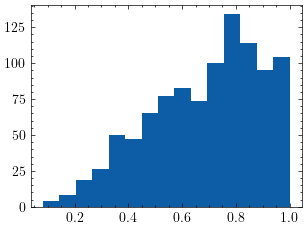

In [34]:
plt.figure()
plt.hist(samples["p_null"], bins="auto")
plt.show()

In [6]:
# total = 0
# for obs_idx, halo_idx in groups:
#     n_assignments = len(cmbo.match.generate_valid_assignments(len(obs_idx), len(halo_idx)))
#     total += n_assignments
#     print(f"Group ({len(obs_idx)} obs, {len(halo_idx)} halos): {n_assignments} assignments")

# print(f"Total assignments: {total}")


In [32]:
res[1]

Array([[0.42000607],
       [0.98117006]], dtype=float32)

In [34]:
groups[1]

(array([ 0, 75]), array([37]))

In [19]:
sum([len(gr[1]) for gr in groups])

45

In [20]:
len(x_halo)

135

In [16]:
len(x_obs)

76

In [11]:
groups[0]

(array([30]), array([112]))